In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm
from tqdm import trange, tqdm

In [38]:
class WeatherDataset(Dataset):
    def __init__(self, dataset_file, day_range, split_date, train_test="train"):

        # (Date, rainfall, maximum temp)
        df = pd.read_csv(dataset_file)
        # Turn date column into datetime type
        df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime
        
        # Set the Date as the index
        df.set_index('Date', inplace=True)
        
        # Normalize the data
        mean = df.mean()
        std = df.std()
        df = (df - mean) / std

        # Calculate the mean and std dev
        self.mean = torch.tensor(mean.to_numpy()).reshape(1, -1)
        self.std = torch.tensor(std.to_numpy()).reshape(1, -1)

        # Get corresponding split
        if train_test == "train":
            self.dataset = df[df.index < split_date]
        elif train_test == "test":
            self.dataset = df[df.index >= split_date]
        else:
            ValueError("train_test should be train or test")

        # Get the day_range (# of days to take in as input)
        self.day_range = day_range
    
    def __getitem__(self, index):

        # Index a range of days
        end_index = index + self.day_range
        
        # One single item counts as 
        current_series = self.dataset.iloc[index:end_index]

        # Index the index column, and index into day, month
        # current_series.values returns the corresponding rainfall and maximum temperature
        day_tensor = torch.LongTensor(current_series.index.day.to_numpy())
        month_tensor = torch.LongTensor(current_series.index.month.to_numpy())
        data_values = torch.FloatTensor(current_series.values)

        return day_tensor, month_tensor, data_values

    def __len__(self):
        # __len__(,..,) is also used for determining when the end of a dataset is reached!
        # Exactly when len(self.dataset) - self.day_range == 0
        return len(self.dataset) - self.day_range


In [59]:
dataset_file = "weather.csv"

split_date = pd.to_datetime('2023-01-01')

day_range = 15

days_in = 14

assert day_range > days_in, "The total day range must be larger than the input days for the MLP"

learning_rate = 1e-4  
nepochs = 500  
batch_size = 32  

dataset_train = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="train")
dataset_test = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="test")
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)

In [43]:
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(input_size)
        # First fully connected layer that reduces the dimensionality by half
        self.fc1 = nn.Linear(input_size, input_size // 2)
        
        # Layer normalization after the first fully connected layer
        self.norm2 = nn.LayerNorm(input_size // 2)
        # Second fully connected layer that outputs the desired output size
        self.fc2 = nn.Linear(input_size // 2, output_size)
        
        # Skip connection layer to match the output size
        self.fc3 = nn.Linear(input_size, output_size)

        # Activation function
        self.act = nn.ELU()

    def forward(self, x):
        # Apply normalization and activation function to the input
        x = self.act(self.norm1(x))
        # Compute the skip connection output
        skip = self.fc3(x)
        
        # Apply the first fully connected layer, normalization, and activation function
        x = self.act(self.norm2(self.fc1(x)))
        # Apply the second fully connected layer
        x = self.fc2(x)
        
        # Add the skip connection to the output
        return x + skip


class RNN(nn.Module):
    def __init__(self, seq_len, output_size, num_blocks=1, buffer_size=128):
        super(RNN, self).__init__()
        
        # Compute the length of the sequence data
        seq_data_len = seq_len * 2

        # Define the input MLP with two fully connected layers and activation functions
        self.input_mlp = nn.Sequential(
            nn.Linear(seq_data_len, 4 * seq_data_len),
            nn.ELU(),
            nn.Linear(4 * seq_data_len, 128),
            nn.ELU()
        )

        # Define the RNN layer
        # Concatenates the input sequence with the buffer and feeds it through a linear layer
        self.rnn = nn.Linear(256, 128)
        
        # Define the sequence of residual blocks
        blocks = [ResBlockMLP(128, 128) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        
        # Final output fully connected layer
        self.fc_out = nn.Linear(128, output_size)
        
        # Fully connected layer for the buffer
        self.fc_buffer = nn.Linear(128, buffer_size)
        
        # Activation function
        self.act = nn.ELU()

    def forward(self, input_seq, buffer_in):
        # Reshape the input sequence to a flat vector
        input_seq = input_seq.reshape(input_seq.shape[0], -1)
        # Pass the input sequence through the input MLP
        input_vec = self.input_mlp(input_seq)
        
        # Concatenate the previous step buffer with the input vector
        x_cat = torch.cat((buffer_in, input_vec), 1)
        
        # Pass the concatenated vector through the RNN layer
        x = self.rnn(x_cat)

        # Pass the output through the sequence of residual blocks
        x = self.act(self.res_blocks(x))
        
        # Compute the final output and the updated buffer
        return self.fc_out(x), torch.tanh(self.fc_buffer(x))


In [44]:
# Set device to GPU if available, otherwise CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Define buffer size
buffer_size = 128

# Create RNN model and move it to the specified device
weather_rnn = RNN(seq_len=days_in, output_size=2, buffer_size=buffer_size).to(device)

# Initialize Adam optimizer with specified learning rate
optimizer = optim.Adam(weather_rnn.parameters(), lr=learning_rate)

# Define Mean Squared Error (MSE) loss function
loss_fn = nn.MSELoss()

# Initialize training loss logger
training_loss_logger = []

In [45]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in weather_rnn.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 100850 (Approximately 0 Million) Parameters!


In [52]:
# Iterate over epochs
for epoch in range(nepochs):
    # Set the model to training mode
    weather_rnn.train()
    
    # Iterate over batches in training data
    for day, month, data_seq in data_loader_train:
        # Extract input sequence block and move to device
        seq_block = data_seq[:, :days_in].to(device)
        
        # Initialize the buffer with zeros
        buffer = torch.zeros(data_seq.shape[0], buffer_size, device=device)
        
        # Initialize loss
        loss = 0
        
        # Iterate over time steps
        for i in range(day_range - days_in):
            # Extract target sequence block and move to device
            target_seq_block = data_seq[:, i + days_in].to(device)
            
            # Forward pass: Get predictions and update buffer
            data_pred, buffer = weather_rnn(seq_block, buffer)
            
            # Compute loss
            loss += loss_fn(data_pred, target_seq_block)

            # Update input sequence block by removing the oldest prediction and adding the new prediction
            seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1).detach()), 1)
            
        # Calculate average loss
        loss /= i + 1
        
        # Backpropagation: Zero gradients, compute gradients, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log the training loss
        training_loss_logger.append(loss.item())
    print(f"loss: {loss}")

loss: 0.33099600672721863
loss: 0.3920873999595642
loss: 0.38709887862205505
loss: 0.6802911758422852
loss: 0.3868461847305298
loss: 0.5235493183135986
loss: 0.6808931827545166
loss: 1.0423330068588257
loss: 1.0506091117858887
loss: 0.6492488384246826
loss: 0.266401469707489
loss: 0.2495700716972351
loss: 0.3264889419078827
loss: 0.3618118166923523
loss: 0.9862056374549866
loss: 0.3544030785560608
loss: 0.5817069411277771
loss: 1.0267434120178223
loss: 0.5500413775444031
loss: 0.3038926422595978
loss: 0.883004903793335
loss: 0.26041585206985474
loss: 0.433584988117218
loss: 0.27867400646209717
loss: 0.2442604899406433
loss: 0.1872452199459076
loss: 0.5307090878486633
loss: 0.9479568004608154
loss: 0.5227658152580261
loss: 0.2996297776699066
loss: 0.5401747226715088
loss: 0.27750343084335327
loss: 0.37054702639579773
loss: 0.2875050902366638
loss: 0.3424748182296753
loss: 0.3637259006500244
loss: 0.28657713532447815
loss: 0.5194745063781738
loss: 0.2706946134567261
loss: 0.2738848328590

KeyboardInterrupt: 

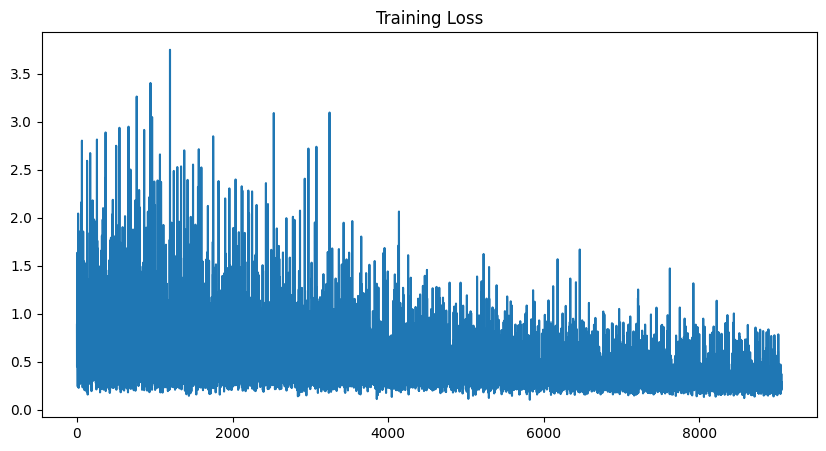

In [53]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger)
_ = plt.title("Training Loss")

In [54]:
# Convert test dataset values to a PyTorch tensor
data_tensor = torch.FloatTensor(dataset_test.dataset.values)

# Initialize an empty list to store predictions
log_predictions = []

# Set the model to evaluation mode
weather_rnn.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    # Initialize the input sequence block and buffer
    seq_block = data_tensor[:days_in, :].unsqueeze(0).to(device)
    buffer = torch.zeros(seq_block.shape[0], buffer_size, device=device)
    
    # Iterate over the test data, performing autoregressive prediction
    for i in range(data_tensor.shape[0] - days_in):
        # Get predictions and update buffer
        data_pred, buffer = weather_rnn(seq_block, buffer)
        # Append predictions to the list
        log_predictions.append(data_pred.cpu())

        # Update input sequence block by removing the oldest prediction and adding the new prediction
        seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1)

# Concatenate the logged predictions into a single tensor
predictions_cat = torch.cat(log_predictions)

# Unnormalize the predictions and original data using dataset's standard deviation and mean
un_norm_predictions = (predictions_cat * dataset_test.std) + dataset_test.mean
un_norm_data = (data_tensor * dataset_test.std) + dataset_test.mean

# Trim the initial sequence from the unnormalized data to match the length of predictions
un_norm_data = un_norm_data[days_in:]

In [55]:
# Uncomment to use!
# Convert test dataset values to a PyTorch tensor
data_tensor = torch.FloatTensor(dataset_test.dataset.values)

# Initialize an empty list to store predictions
log_predictions = []

# Set the model to evaluation mode
weather_rnn.eval()

# Initialize buffer with zeros
buffer = torch.zeros(1, buffer_size, device=device)

# Iterate over the first 30 time steps
for i in range(30):
    # Extract input sequence block for prediction
    seq_block = data_tensor[i:(i + days_in), :].unsqueeze(0).to(device)
    
    # Predict using the input sequence block and buffer
    data_pred, buffer = weather_rnn(seq_block, buffer)
    
    # Append prediction to the list
    log_predictions.append(data_pred.cpu())

# Continue predicting for the remaining time steps
for j in range(data_tensor.shape[0] - days_in - 30):
    # Update input sequence block by removing the oldest prediction and adding the new prediction
    seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1)
    
    # Predict using the updated input sequence block and buffer
    data_pred, buffer = weather_rnn(seq_block, buffer)
    
    # Append prediction to the list
    log_predictions.append(data_pred.cpu())

# Concatenate the logged predictions into a single tensor
predictions_cat = torch.cat(log_predictions)

# Unnormalize the predictions and original data using dataset's standard deviation and mean
un_norm_predictions = (predictions_cat * dataset_test.std) + dataset_test.mean
un_norm_data = (data_tensor * dataset_test.std) + dataset_test.mean
un_norm_data = un_norm_data[days_in:]

In [56]:
test_mse = (un_norm_data - un_norm_predictions).pow(2).mean().item()
print("Test MSE value %.2f" % test_mse)

Test MSE value 55.90


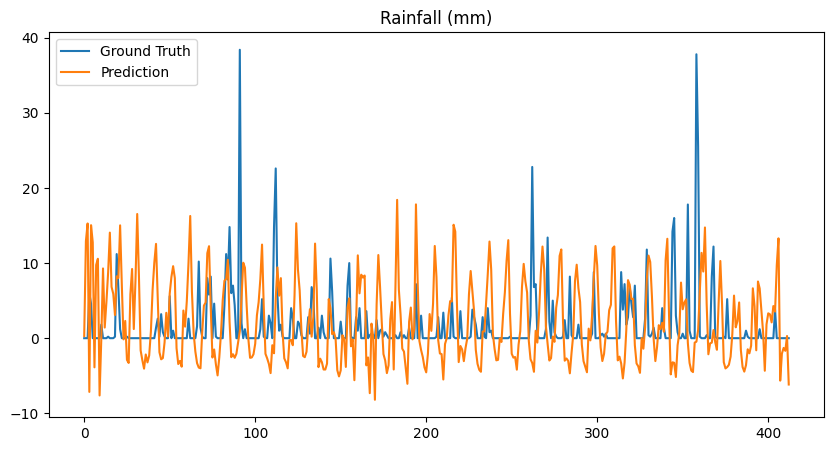

In [57]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(un_norm_data[:, 0].detach().numpy())
_ = plt.plot(un_norm_predictions[:, 0].detach().numpy())
_ = plt.title("Rainfall (mm)")

_ = plt.legend(["Ground Truth", "Prediction"])

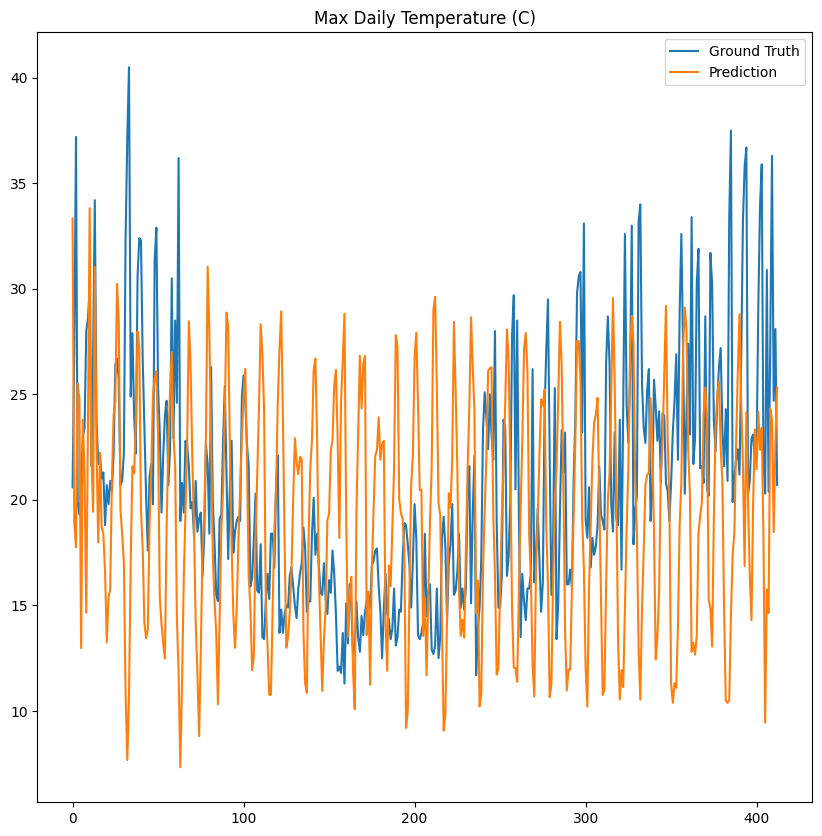

In [58]:
_ = plt.figure(figsize=(10, 10))
_ = plt.plot(un_norm_data[:, 1].detach().numpy())
_ = plt.plot(un_norm_predictions[:, 1].detach().numpy())
_ = plt.title("Max Daily Temperature (C)")

_ = plt.legend(["Ground Truth", "Prediction"])